# Aim and motivation
The primary reason I have chosen to create this kernel is to practice and use RNNs for various tasks and applications. First of which is time series data. RNNs have truly changed the way sequential data is forecasted. My goal here is to create the ultimate reference for RNNs here on kaggle.

## Recurrent Neural Networks
In a recurrent neural network we store the output activations from one or more of the layers of the network. Often these are hidden later activations. Then, the next time we feed an input example to the network, we include the previously-stored outputs as additional inputs. You can think of the additional inputs as being concatenated to the end of the “normal” inputs to the previous layer. For example, if a hidden layer had 10 regular input nodes and 128 hidden nodes in the layer, then it would actually have 138 total inputs (assuming you are feeding the layer’s outputs into itself à la Elman) rather than into another layer). Of course, the very first time you try to compute the output of the network you’ll need to fill in those extra 128 inputs with 0s or something.

Source: [Quora](https://www.quora.com/What-is-a-simple-explanation-of-a-recurrent-neural-network)
<img src="https://cdn-images-1.medium.com/max/1600/1*NKhwsOYNUT5xU7Pyf6Znhg.png">

Source: [Medium](https://medium.com/ai-journal/lstm-gru-recurrent-neural-networks-81fe2bcdf1f9)

Let me give you the best explanation of Recurrent Neural Networks that I found on internet: https://www.youtube.com/watch?v=UNmqTiOnRfg&t=3s

Now, even though RNNs are quite powerful, they suffer from  **Vanishing gradient problem ** which hinders them from using long term information, like they are good for storing memory 3-4 instances of past iterations but larger number of instances don't provide good results so we don't just use regular RNNs. Instead, we use a better variation of RNNs: **Long Short Term Networks(LSTM).**

### What is Vanishing Gradient problem?
Vanishing gradient problem is a difficulty found in training artificial neural networks with gradient-based learning methods and backpropagation. In such methods, each of the neural network's weights receives an update proportional to the partial derivative of the error function with respect to the current weight in each iteration of training. The problem is that in some cases, the gradient will be vanishingly small, effectively preventing the weight from changing its value. In the worst case, this may completely stop the neural network from further training. As one example of the problem cause, traditional activation functions such as the hyperbolic tangent function have gradients in the range (0, 1), and backpropagation computes gradients by the chain rule. This has the effect of multiplying n of these small numbers to compute gradients of the "front" layers in an n-layer network, meaning that the gradient (error signal) decreases exponentially with n while the front layers train very slowly.

Source: [Wikipedia](https://en.wikipedia.org/wiki/Vanishing_gradient_problem)

<img src="https://cdn-images-1.medium.com/max/1460/1*FWy4STsp8k0M5Yd8LifG_Q.png">

Source: [Medium](https://medium.com/@anishsingh20/the-vanishing-gradient-problem-48ae7f501257)

## Long Short Term Memory(LSTM)
Long short-term memory (LSTM) units (or blocks) are a building unit for layers of a recurrent neural network (RNN). A RNN composed of LSTM units is often called an LSTM network. A common LSTM unit is composed of a cell, an input gate, an output gate and a forget gate. The cell is responsible for "remembering" values over arbitrary time intervals; hence the word "memory" in LSTM. Each of the three gates can be thought of as a "conventional" artificial neuron, as in a multi-layer (or feedforward) neural network: that is, they compute an activation (using an activation function) of a weighted sum. Intuitively, they can be thought as regulators of the flow of values that goes through the connections of the LSTM; hence the denotation "gate". There are connections between these gates and the cell.

The expression long short-term refers to the fact that LSTM is a model for the short-term memory which can last for a long period of time. An LSTM is well-suited to classify, process and predict time series given time lags of unknown size and duration between important events. LSTMs were developed to deal with the exploding and vanishing gradient problem when training traditional RNNs.

Source: [Wikipedia](https://en.wikipedia.org/wiki/Long_short-term_memory)

<img src="https://cdn-images-1.medium.com/max/1600/0*LyfY3Mow9eCYlj7o.">

Source: [Medium](https://codeburst.io/generating-text-using-an-lstm-network-no-libraries-2dff88a3968)

The best LSTM explanation on internet: https://medium.com/deep-math-machine-learning-ai/chapter-10-1-deepnlp-lstm-long-short-term-memory-networks-with-math-21477f8e4235

Refer above link for deeper insights.

## Components of LSTMs
So the LSTM cell contains the following components
* Forget Gate “f” ( a neural network with sigmoid)
* Candidate layer “C"(a NN with Tanh)
* Input Gate “I” ( a NN with sigmoid )
* Output Gate “O”( a NN with sigmoid)
* Hidden state “H” ( a vector )
* Memory state “C” ( a vector)

* Inputs to the LSTM cell at any step are X<sub>t</sub> (current input) , H<sub>t-1</sub> (previous hidden state ) and C<sub>t-1</sub> (previous memory state).  
* Outputs from the LSTM cell are H<sub>t</sub> (current hidden state ) and C<sub>t</sub> (current memory state)

## Working of gates in LSTMs
First, LSTM cell takes the previous memory state C<sub>t-1</sub> and does element wise multiplication with forget gate (f) to decide if  present memory state C<sub>t</sub>. If forget gate value is 0 then previous memory state is completely forgotten else f forget gate value is 1 then previous memory state is completely passed to the cell ( Remember f gate gives values between 0 and 1 ).

**C<sub>t</sub> = C<sub>t-1</sub> * f<sub>t</sub>**

Calculating the new memory state: 

**C<sub>t</sub> = C<sub>t</sub> + (I<sub>t</sub> * C\`<sub>t</sub>)**

Now, we calculate the output:

**H<sub>t</sub> = tanh(C<sub>t</sub>)**

### And now we get to the code...
I will use LSTMs for predicting the price of stocks of IBM for the year 2017

In [27]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from keras.optimizers import SGD, Adam
import math
from sklearn.metrics import mean_squared_error

In [28]:
# Some functions to help out with
def plot_predictions(test,predicted):
    plt.plot(test, color='red',label='Real IBM Stock Price')
    plt.plot(predicted, color='blue',label='Predicted IBM Stock Price')
    plt.title('IBM Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('IBM Stock Price')
    plt.legend()
    plt.show()

# We will be using RMSE to test our model
def return_rmse(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))

In [29]:
# First, we get the data
dataset = pd.read_csv('IBM_2006-01-01_to_2018-01-01.csv', index_col='Date', parse_dates=['Date'])
dataset.head()

,Open,High,Low,Close,Volume,Name
Date,,,,,,
2006-01-03,82.45,82.55,80.81,82.06,11715200,IBM
2006-01-04,82.20,82.50,81.33,81.95,9840600,IBM
2006-01-05,81.40,82.90,81.00,82.50,7213500,IBM
2006-01-06,83.95,85.03,83.41,84.95,8197400,IBM
2006-01-09,84.10,84.25,83.38,83.73,6858200,IBM


In [30]:
# We are only considering HIGH values
dataset[:'2006-01'].iloc[:,1:2]

,High
Date,
2006-01-03,82.55
2006-01-04,82.50
2006-01-05,82.90
2006-01-06,85.03
2006-01-09,84.25
2006-01-10,84.12
2006-01-11,84.81
2006-01-12,83.96
2006-01-13,83.45


In [31]:
# All data till 2016 in training and rest in test[ONLY HIGH values]
training_set = dataset[:'2016'].iloc[:,1:2].values
test_set = dataset['2017':].iloc[:,1:2].values

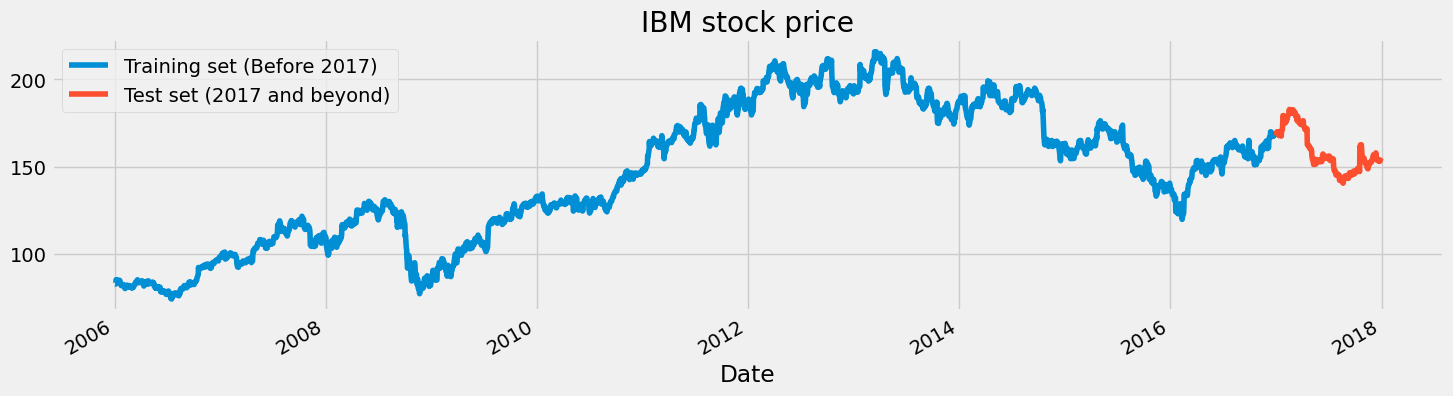

In [32]:
# We have chosen 'High' attribute for prices. Let's see what it looks like
dataset["High"][:'2016'].plot(figsize=(16,4),legend=True)
dataset["High"]['2017':].plot(figsize=(16,4),legend=True)
plt.legend(['Training set (Before 2017)','Test set (2017 and beyond)'])
plt.title('IBM stock price')
plt.show()

In [33]:
# Scaling the training set
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(training_set)

In [34]:
training_set_scaled.shape

(2769, 1)

In [35]:
# Since LSTMs store long term memory state, 
# we create a data structure with 60 timesteps and 1 output
# So for each element of training set,
# we have 60 previous training set elements 

X_train = []
y_train = []
for i in range(60,2769):
#     print(i-60,i)
    X_train.append(training_set_scaled[i-60:i,0])
    y_train.append(training_set_scaled[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)

In [36]:
training_set_scaled[0:11,0]

array([0.06065089, 0.06029868, 0.06311637, 0.0781206 , 0.07262609,
       0.07171034, 0.07657087, 0.07058326, 0.0669907 , 0.06494787,
       0.075796  ])

In [37]:
training_set_scaled[10,0]

0.07579599887292199

In [38]:
print(X_train.shape[0],X_train.shape[1])

2709 60


In [39]:
print(X_train.shape)

(2709, 60)


In [40]:
# Reshaping X_train for efficient modelling
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

In [41]:
X_train.shape

(2709, 60, 1)

In [42]:
X_train[0].shape

(60, 1)

In [43]:
# The LSTM architecture
regressor = Sequential()
# First LSTM layer with Dropout regularisation
regressor.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
regressor.add(Dropout(0.2))
# Second LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
# Third LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
# Fourth LSTM layer
regressor.add(LSTM(units=50))
regressor.add(Dropout(0.2))
# The output layer
regressor.add(Dense(units=1))

# Compiling the RNN
regressor.compile(optimizer='rmsprop',loss='mean_squared_error')
# Fitting to the training set
regressor.fit(X_train,y_train,epochs=5,batch_size=32,verbose=True)

Epoch 1/5


C:\Users\arvenka\AppData\Local\anaconda3\envs\tensorflow\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


85/85 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - loss: 0.0371
Epoch 2/5
85/85 ━━━━━━━━━━━━━━━━━━━━ 5s 53ms/step - loss: 0.0112
Epoch 3/5
85/85 ━━━━━━━━━━━━━━━━━━━━ 5s 55ms/step - loss: 0.0094
Epoch 4/5
85/85 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - loss: 0.0073
Epoch 5/5
85/85 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - loss: 0.0071


In [44]:
# Now to get the test set ready in a similar way as the training set.
# The following has been done so forst 60 entires of test set have 60 previous values which is impossible to get unless we take the whole 
# 'High' attribute data for processing
dataset_total = pd.concat((dataset["High"][:'2016'],dataset["High"]['2017':]),axis=0)
inputs = dataset_total[len(dataset_total)-len(test_set) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = sc.transform(inputs)

In [45]:
# Preparing X_test and predicting the prices
X_test = []
for i in range(60,311):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step


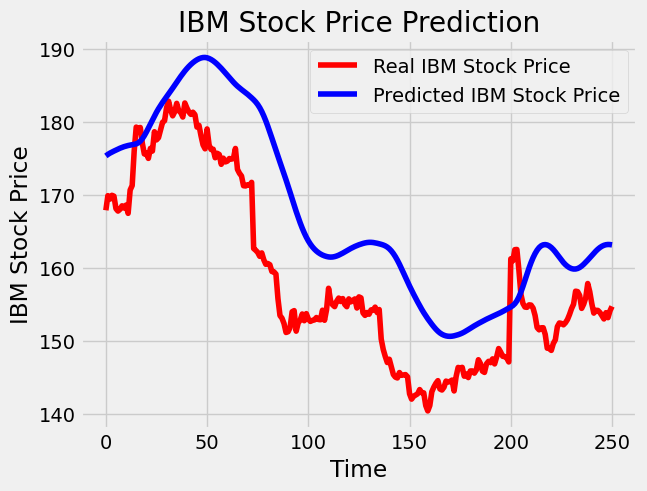

In [46]:
# Visualizing the results for LSTM
plot_predictions(test_set,predicted_stock_price)

In [47]:
# Evaluating our model
return_rmse(test_set,predicted_stock_price)

The root mean squared error is 10.218791113468015.


Truth be told. That's one awesome score. 

LSTM is not the only kind of unit that has taken the world of Deep Learning by a storm. We have **Gated Recurrent Units(GRU)**. It's not known, which is better: GRU or LSTM becuase they have comparable performances. GRUs are easier to train than LSTMs.

## Gated Recurrent Units
In simple words, the GRU unit does not have to use a memory unit to control the flow of information like the LSTM unit. It can directly makes use of the all hidden states without any control. GRUs have fewer parameters and thus may train a bit faster or need less data to generalize. But, with large data, the LSTMs with higher expressiveness may lead to better results.

They are almost similar to LSTMs except that they have two gates: reset gate and update gate. Reset gate determines how to combine new input to previous memory and update gate determines how much of the previous state to keep. Update gate in GRU is what input gate and forget gate were in LSTM. We don't have the second non linearity in GRU before calculating the outpu, .neither they have the output gate.

Source: [Quora](https://www.quora.com/Whats-the-difference-between-LSTM-and-GRU-Why-are-GRU-efficient-to-train)

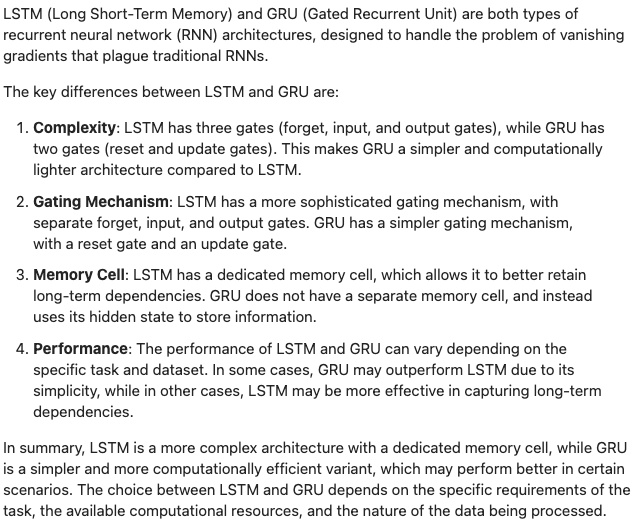

The differences between LSTM and GRU in simpler terms could be:

Complexity:

LSTM: Think of LSTM like a Swiss army knife with three different tools (gates) to control information. It can remember things for a long time.
GRU: GRU is like a simpler tool with only two functions (gates). It's more straightforward and less resource-intensive.

Gates:

LSTM: LSTM has an "input gate," a "forget gate," and an "output gate." These gates control the flow of information through the network.
GRU: GRU has a "reset gate" and an "update gate." These two gates handle the flow of information.

Memory:

LSTM: It uses a separate "memory cell" to remember things for an extended period.
GRU: Instead of a separate memory cell, GRU combines the memory and hidden state into one, making it more compact.

Training Speed:

LSTM: LSTM networks are like a luxury car - powerful but slower and resource-hungry.
GRU: GRU is like a reliable, fuel-efficient car - simpler and faster to train.

Performance:

LSTM: LSTM shines in tasks where you need a good memory of past events and complex patterns.
GRU: GRU works well in many situations and is known for being simple and efficient. It's great for tasks with shorter-term dependencies.

Use Cases:

LSTM: Choose LSTM when your data has complex, long-term patterns and you can afford the extra computational cost.
GRU: Go with GRU when you need a faster and more straightforward model, and your data involves shorter-term patterns.

In simple terms, LSTM is like a powerful, memory-packed computer, while GRU is like a speedy, efficient laptop. Your choice depends on the kind of tasks you have and the resources you're willing to allocate.

In [51]:
# The GRU architecture
regressorGRU = Sequential()
# First GRU layer with Dropout regularisation
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Second GRU layer
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Third GRU layer
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Fourth GRU layer
regressorGRU.add(GRU(units=50, activation='tanh'))
regressorGRU.add(Dropout(0.2))
# The output layer
regressorGRU.add(Dense(units=1))
# Compiling the RNN
regressorGRU.compile(optimizer=SGD(learning_rate=0.01, decay=1e-7, momentum=0.9, nesterov=False),loss='mean_squared_error')
# Fitting to the training set
regressorGRU.fit(X_train,y_train,epochs=50,batch_size=150)

Epoch 1/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - loss: 0.2145
Epoch 2/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 137ms/step - loss: 0.0538
Epoch 3/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - loss: 0.0177
Epoch 4/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 135ms/step - loss: 0.0052
Epoch 5/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - loss: 0.0044
Epoch 6/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 165ms/step - loss: 0.0044
Epoch 7/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 166ms/step - loss: 0.0037
Epoch 8/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 151ms/step - loss: 0.0035
Epoch 9/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step - loss: 0.0033
Epoch 10/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 135ms/step - loss: 0.0033
Epoch 11/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 171ms/step - loss: 0.0033
Epoch 12/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 190ms/step - loss: 0.0034
Epoch 13/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 185ms/step - loss: 0.0030
Epoch 14/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 162ms/step - loss: 0.0032
Epoch 15/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 152ms/step - lo

The current version version uses a dense GRU network with 100 units as opposed to the GRU network with 50 units in previous version

In [52]:
# Preparing X_test and predicting the prices
X_test = []
for i in range(60,311):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
GRU_predicted_stock_price = regressorGRU.predict(X_test)
GRU_predicted_stock_price = sc.inverse_transform(GRU_predicted_stock_price)

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step


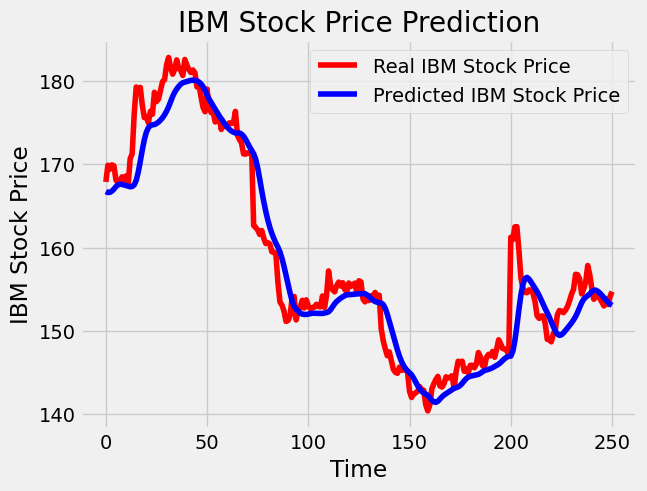

In [53]:
# Visualizing the results for GRU
plot_predictions(test_set,GRU_predicted_stock_price)

In [55]:
# Evaluating GRU
return_rmse(test_set,GRU_predicted_stock_price)

The root mean squared error is 3.2219734009565557.


## Sequence Generation
Here, I will generate a sequence using just initial 60 values instead of using last 60 values for every new prediction. **Due to doubts in various comments about predictions making use of test set values, I have decided to include sequence generation.** The above models make use of test set so it is using last 60 true values for predicting the new value(I will call it a benchmark). This is why the error is so low. Strong models can bring similar results like above models for sequences too but they require more than just data which has previous values. In case of stocks, we need to know the sentiments of the market, the movement of other stocks and a lot more. So, don't expect a remotely accurate plot. The error will be great and the best I can do is generate the trend similar to the test set.

I will use GRU model for predictions. You can try this using LSTMs also. I have modified GRU model above to get the best sequence possible. I have run the model four times and two times I got error of around 8 to 9. The worst case had an error of around 11. Let's see what this iterations.

The GRU model in the previous versions is fine too. Just a little tweaking was required to get good sequences. **The main goal of this kernel is to show how to build RNN models. How you predict data and what kind of data you predict is up to you. I can't give you some 100 lines of code where you put the destination of training and test set and get world-class results. That's something you have to do yourself.**

In [56]:
# Preparing sequence data
initial_sequence = X_train[2708,:]
sequence = []
for i in range(251):
    new_prediction = regressorGRU.predict(initial_sequence.reshape(initial_sequence.shape[1],initial_sequence.shape[0],1))
    initial_sequence = initial_sequence[1:]
    initial_sequence = np.append(initial_sequence,new_prediction,axis=0)
    sequence.append(new_prediction)
sequence = sc.inverse_transform(np.array(sequence).reshape(251,1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━

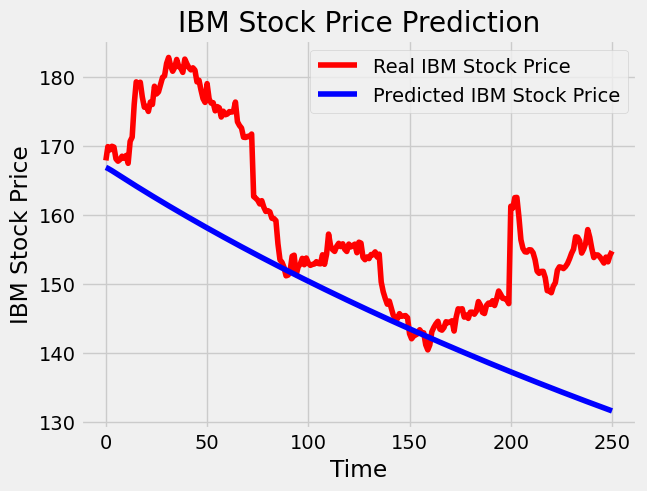

In [57]:
# Visualizing the sequence
plot_predictions(test_set,sequence)

In [58]:
# Evaluating the sequence
return_rmse(test_set,sequence)

The root mean squared error is 13.387874399065488.


So, GRU works better than LSTM in this case. Bidirectional LSTM is also a good way so make the model stronger. But this may vary for different data sets. **Applying both LSTM and GRU together gave even better results.** 

#### I was going to cover text generation using LSTM but already an excellent kernel by [Shivam Bansal](https://www.kaggle.com/shivamb) on the mentioned topic exists. Link for that kernel here: https://www.kaggle.com/shivamb/beginners-guide-to-text-generation-using-lstms

#### This is certainly not the end. Stay tuned for more stuff!